# Laboratorio 1 Fundamentos de Aprendizaje Profundo

Nombre: Antonina Arriagada

### 1. Definiciones e importación librerias

In [58]:
import torch
import torch.nn as nn
import time
import sys
import random
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import numpy as np
import seaborn as sns

In [59]:
def set_seed(seed=43):
    random.seed(seed)  # Semilla para la aleatoriedad de Python
    np.random.seed(seed)  # Semilla para NumPy
    torch.manual_seed(seed)  # Semilla para PyTorch en CPU
    torch.cuda.manual_seed(seed)  # Semilla para PyTorch en GPU
    torch.cuda.manual_seed_all(seed)  # Semilla para todas las GPUs (si tienes múltiples)
    torch.backends.cudnn.deterministic = True  # Garantiza determinismo en convoluciones
    torch.backends.cudnn.benchmark = False  # Desactiva optimizaciones no deterministas
set_seed(43)

#### 1.1 Definición de la red

In [60]:
class SimpleFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1):
        super(SimpleFFNN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.fc3 = nn.Linear(hidden_size2, output_size, bias=True)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.tanh(self.fc2(h1))
        return torch.sigmoid(self.fc3(h2))
    
    def num_parameters(self):
        total = 0
        for p in self.parameters():
            total += p.numel()
        return total

#### 1.2 Definición de dataset y preprocesamiento de datos

RandomDataset

In [61]:
class RandomDataSet(Dataset):
    def __init__(self, N, f):
        R_N_f = torch.rand(N, f)
        self.X = torch.bernoulli(R_N_f)
        R_N_1 = torch.rand(N, 1)
        self.Y = torch.bernoulli(R_N_1)
        self.num_features = f

    def __len__(self):
        return self.X.size()[0]

    def __getitem__(self, i):
        return self.X[i], self.Y[i]


Dataset de clasificación binaria

In [62]:
weather_data = pd.read_csv("dataset/weather.csv")
weather_data.describe()


,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,25000.000000,24669.000000,24824.000000,24721.000000,9432.000000,6664.000000,21545.000000,24428.000000,23770.000000,24609.000000,23936.000000,20172.000000,20173.000000,14136.000000,13815.000000,24755.000000,24082.000000,25000.000000
mean,12499.500000,13.294568,23.990558,2.674467,5.825138,7.811945,37.772755,12.686917,16.837106,69.822951,52.762826,1018.173290,1015.627438,4.251556,4.409265,17.953084,22.507171,2.677376
std,7217.022701,5.848304,6.114348,9.720306,4.871567,3.718698,13.212331,9.136115,9.095719,17.755908,21.210121,6.481112,6.394829,2.968785,2.719235,5.394685,5.954540,9.705604
min,0.000000,-3.300000,6.800000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,3.000000,1.000000,980.500000,979.000000,0.000000,0.000000,0.300000,6.400000,0.000000
25%,6249.750000,8.900000,19.500000,0.000000,3.000000,5.500000,28.000000,6.000000,9.000000,58.000000,37.000000,1013.800000,1011.300000,1.000000,2.000000,14.200000,18.100000,0.000000
50%,12499.500000,14.000000,23.400000,0.000000,4.800000,8.900000,35.000000,11.000000,17.000000,71.000000,54.000000,1018.200000,1015.700000,5.000000,5.000000,18.400000,21.900000,0.000000
75%,18749.250000,17.900000,27.700000,0.600000,7.200000,10.600000,46.000000,19.000000,22.000000,83.000000,68.000000,1022.600000,1020.000000,7.000000,7.000000,21.900000,26.100000,0.800000
max,24999.000000,29.700000,47.300000,371.000000,86.200000,14.000000,135.000000,130.000000,83.000000,100.000000,100.000000,1039.900000,1036.800000,8.000000,8.000000,37.700000,46.700000,371.000000


In [63]:
print(weather_data.columns)


Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')


In [64]:
from sklearn.preprocessing import StandardScaler

weather_data.drop(columns=['Unnamed: 0', 'Date'], inplace=True)

numeric_columns = weather_data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = weather_data.select_dtypes(include=['object']).columns

# Se llenan espacios vacíos
weather_data[numeric_columns] = weather_data[numeric_columns].fillna(weather_data[numeric_columns].median())

# se conviertes las variables categóricas en columnas binarias
weather_data = weather_data.apply(lambda x: x.fillna(x.mode()[0]) if x.name in categorical_columns else x)
weather_data = pd.get_dummies(weather_data, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location'])

Los datos numéricos se están escalando y normalizando utilizando el método StandardScaler de sklearn, que ajusta cada característica numérica a fin de  tener una media de 0 y una desviación estándar de 1.

In [65]:
scaler = StandardScaler() 
weather_data[numeric_columns] = scaler.fit_transform(weather_data[numeric_columns])

In [103]:
weather_data['RainTomorrow'] = weather_data['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

MNIST

In [66]:
from torchvision import datasets, transforms

#  normalización de las imágenes en escala de grises, centrándolas en un valor medio de 0 y escalándolas para que los valores estén entre -1 y 1.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./dataset', train=False, download=True, transform=transform)


In [67]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [68]:
images, labels = next(iter(train_loader))
print(f'Batch images shape: {images.shape}, Batch labels shape: {labels.shape}')

Batch images shape: torch.Size([64, 1, 28, 28]), Batch labels shape: torch.Size([64])


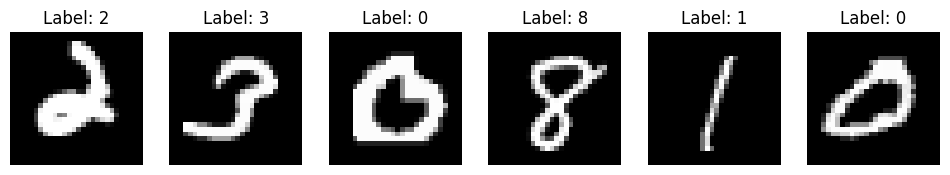

In [69]:
images = images * 0.5 + 0.5 

fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray') 
    axes[i].set_title(f'Label: {labels[i].item()}')
    axes[i].axis('off')
plt.show()

### 2. Inicialización de pesos

El estudiante debe documentar las observaciones sobre cómo la inicialización 
de los pesos y la normalización de los datos afectan la estabilidad del 
entrenamiento, la rapidez de la convergencia y el rendimiento final del modelo.

Inicialización de Xavier (o Glorot): Ideal para redes con funciones de 
activación simétricas como tanh o sigmoid, y mejora la propagación de 
los gradientes en redes profundas.

Inicialización de He: Recomendada para redes con funciones de 
activación como ReLU, ya que ayuda a manejar el problema del 
desvanecimiento de gradientes.

Sugerencia de análisis: Comparar los resultados obtenidos con cada 
optimizador e inicialización utilizando métricas como la pérdida de 
entrenamiento y precisión, además de visualizar las curvas de aprendizaje 
para cada configuración.

#### 2.1 Inicialización de Xavier

La inicialización de Xavier (también conocida como Glorot) se usa típicamente con activaciones sigmoides o tangentes hiperbólicas (tanh). La función de Xavier ajusta los pesos para que sigan una distribución uniforme o normal con una varianza específica que ayuda a estabilizar la activación en cada capa.

In [70]:
def init_xavier(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight) 
            if layer.bias is not None:
                nn.init.zeros_(layer.bias) 

#### 2.2 Inicialización de He

La inicialización de He es ideal cuando se utilizan activaciones ReLU o variantes de ReLU, ya que adapta la varianza de los pesos a la cantidad de neuronas en la capa anterior, ayudando a que las activaciones no se saturen ni se apaguen.

In [71]:
def init_he(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu') 
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

### 3. Optimización

Algoritmos de optimización

##### 3.1 SGD (Descenso de Gradiente Estocástico)

In [72]:
def get_sgd_optimizer(model, lr=0.01, weight_decay=0):
    """SGD Optimizer"""
    return torch.optim.SGD(model.parameters(), lr=lr,  weight_decay=weight_decay)

##### 3.2 SGD con Momentum

In [188]:
def get_sgd_momentum_optimizer(model, lr=0.01, momentum=0.9, weight_decay=0):
    """SGD with Momentum Optimizer"""
    return torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

##### 3.3 SGD con Nesterov Momentum

In [189]:
def get_sgd_nesterov_optimizer(model, lr=0.01, momentum=0.9, weight_decay=0):
    """SGD with Nesterov Momentum Optimizer"""
    return torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=weight_decay)

##### 3.4 RMSProp

In [75]:
def get_rmsprop_optimizer(model, lr=0.01, alpha=0.99):
    """RMSProp Optimizer"""
    return torch.optim.RMSprop(model.parameters(), lr=lr, alpha=alpha)

##### 3.5 Adam

In [76]:
def get_adam_optimizer(model, lr=0.01, betas=(0.9, 0.999)):
    """Adam Optimizer"""
    return torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

### 4. Regularización

##### 4.1 Dropout

Dropout ayuda a reducir el sobreajuste apagando aleatoriamente ciertas unidades durante el entrenamiento. Puedes definir una función que añada capas de dropout a un modelo

In [77]:
class DropoutFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1, dropout_prob=0.5):
        super(DropoutFFNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.fc3 = nn.Linear(hidden_size2, output_size, bias=True)
        self.dropout = nn.Dropout(p=dropout_prob)  # prob de apagar neuronas

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h1 = self.dropout(h1)
        h2 = torch.tanh(self.fc2(h1))
        h2 = self.dropout(h2)
        return torch.sigmoid(self.fc3(h2))
    
    def num_parameters(self):
        total = 0
        for p in self.parameters():
            total += p.numel()
        return total


##### 4.2 Batch Normalization

Batch Normalization se puede aplicar a las capas de manera similar. Esto ayuda a estabilizar el entrenamiento al mantener las activaciones de cada capa en un rango adecuado.

In [78]:
class BatchNormFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1):
        super(BatchNormFFNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.fc3 = nn.Linear(hidden_size2, output_size, bias=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)  
        self.bn2 = nn.BatchNorm1d(hidden_size2)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h1 = self.bn1(h1)
        h2 = torch.tanh(self.fc2(h1))
        h2 = self.bn2(h2)
        
        # Capa de salida
        return torch.sigmoid(self.fc3(h2))
    
    def num_parameters(self):
        total = 0
        for p in self.parameters():
            total += p.numel()
        return total


##### 4.3 Batch Normalization con Dropout con misma probabilidad por capa

In [79]:
class BatchNormDropoutFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1, dropout_rate=0.5):
        super(BatchNormDropoutFFNN, self).__init__()        
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.fc3 = nn.Linear(hidden_size2, output_size, bias=True)        
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size2)        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h1 = self.fc1(x)
        h1 = self.bn1(h1)
        h1 = torch.tanh(h1)
        h1 = self.dropout(h1)
        
        h2 = self.fc2(h1)
        h2 = self.bn2(h2)
        h2 = torch.tanh(h2)
        h2 = self.dropout(h2)
        
        return torch.sigmoid(self.fc3(h2))
    
    def num_parameters(self):
        total = 0
        for p in self.parameters():
            total += p.numel()
        return total

##### 4.4 Regularización L2

La regularización L2 (también llamada decaimiento de peso) se puede agregar directamente en el optimizador, y su valor será aplicado a cada parámetro del modelo.

In [80]:
def l2_regularization(model, lambda_l2):
    l2_norm = sum(param.pow(2.0).sum() for param in model.parameters())
    return lambda_l2 * l2_norm

### 5. Implementación del modelo

Se define una función para graficar las curvas de pérdida de entrenamiento y validación.

In [81]:
def plot_loss_curves(train_losses, val_losses, title="Loss Curves"):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o', linestyle='--')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [82]:
def plot_acc_curves(train_losses, val_losses, title="Accuracy Curves"):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Accuracy', marker='o')
    plt.plot(val_losses, label='Validation Accuracy', marker='o', linestyle='--')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

##### 5.1 Random Dataset

Entrenamiento del modelo:

In [83]:
def train_model_loop(model, optimizer, train_loader, val_loader=None, epochs=20, reports_every=1, device='cuda', l2=False, use_early_stopping=False, patience=5):
    model.to(device)

    print('Model:', model)
    print('Number of parameters:', model.num_parameters())
    l2_lambda = 0.001

    loss = torch.nn.BCELoss()
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], [] 

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    epoch_time_total = 0

    for epoch in range(1, epochs + 1):
        start_time_epoch = time.time()
        epoch_train_loss = 0
        correct_train, total_train = 0, 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            predictions = model.forward(inputs)
            L = loss(predictions, targets)

            if l2: # regularización l2
                l2_reg = sum(param.pow(2.0).sum() for param in model.parameters())
                L += l2_lambda * l2_reg 

            L.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_train_loss += L.item()
            predictions_binary = (predictions >= 0.5).float()
            correct_train += (predictions_binary == targets).sum().item()
            total_train += targets.size(0)

        train_losses.append(epoch_train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        if val_loader:
            model.eval()
            val_loss = 0
            correct_val, total_val = 0, 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    predictions = model.forward(inputs)
                    L = loss(predictions, targets)
                    val_loss += L.item()
                    predictions_binary = (predictions >= 0.5).float()
                    correct_val += (predictions_binary == targets).sum().item()
                    total_val += targets.size(0)

            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(correct_val / total_val)

            if use_early_stopping:
                if val_losses[-1] < best_val_loss:
                    best_val_loss = val_losses[-1]
                    patience_counter = 0
                    best_model_state = model.state_dict() 
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"\nEarly stopping triggered after {epoch} epochs!")
                        model.load_state_dict(best_model_state) 
                        break

        epoch_time_total += time.time() - start_time_epoch

        if epoch % reports_every == 0:
            train_acc_percent = train_accuracies[-1] * 100
            val_acc_percent = (val_accuracies[-1] * 100) if val_loader else 0
            val_loss_display = val_losses[-1] if val_loader else 0
            sys.stdout.write(
                f'\rEpoch:{epoch:03d} '
                f'Train Acc:{train_acc_percent:.2f}% Loss:{train_losses[-1]:.4f} '
                f'Val Acc:{val_acc_percent:.2f}% Loss:{val_loss_display:.4f} '
                f'Time/epoch:{epoch_time_total/epoch:.3f}s'
            )
            sys.stdout.flush()

    return train_losses, val_losses, train_accuracies, val_accuracies


División del dataset en train - validation y test según 70%-15%-15%

In [84]:
total_samples = 5000
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
test_size = total_samples - train_size - val_size
dataset = RandomDataSet(N=total_samples, f=300)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Se definen lotes de cada subconjunto, organiza los datasets en lotes de tamaño 128 (y así aprovechar la capacidad de la gpu nvidia 4060ti 16gb) y los configura para su uso durante el entrenamiento, validación y prueba.

In [85]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(43))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
Number of parameters: 241001
Epoch:020 Train Acc:61.26% Loss:0.6536 Val Acc:50.67% Loss:0.7135 Time/epoch:0.047s

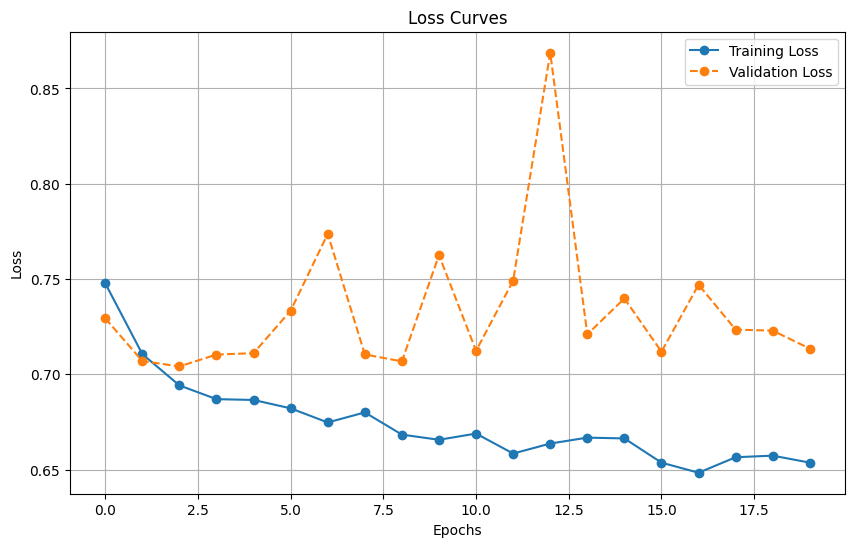

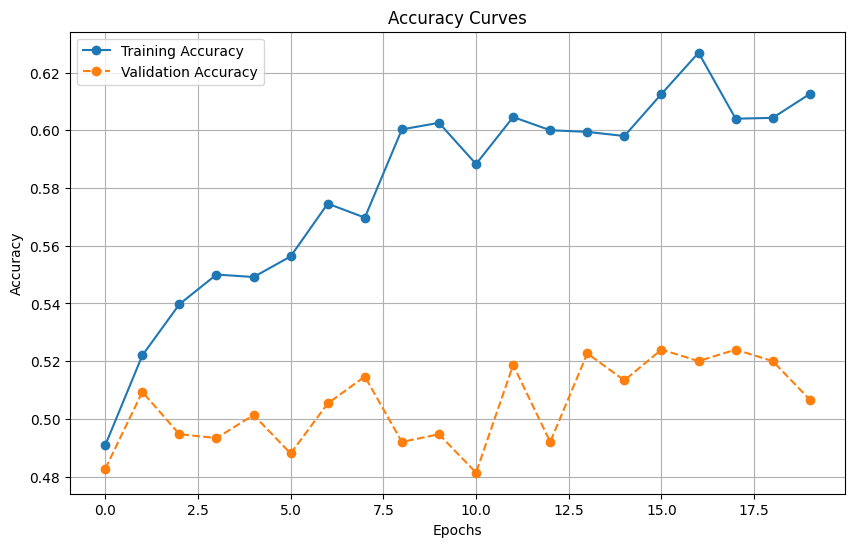

In [339]:
input_size = dataset.num_features 
hidden_size1 = 400
hidden_size2 = 300
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=1, bias=True)
)
Number of parameters: 421401
Epoch:020 Train Acc:61.83% Loss:0.6530 Val Acc:52.00% Loss:0.7069 Time/epoch:0.046s

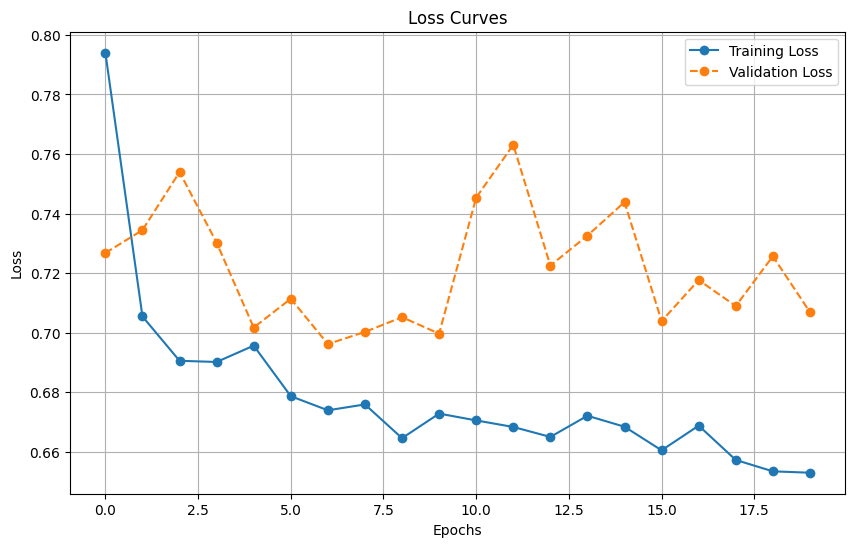

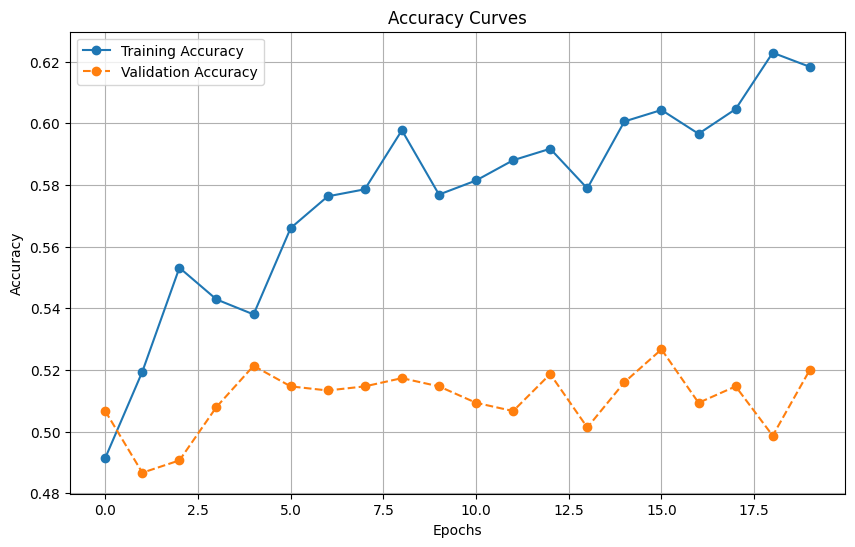

In [340]:
input_size = dataset.num_features 
hidden_size1 = 600
hidden_size2 = 400
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=1, bias=True)
)
Number of parameters: 722001
Epoch:020 Train Acc:60.37% Loss:0.6620 Val Acc:50.40% Loss:0.7492 Time/epoch:0.048s

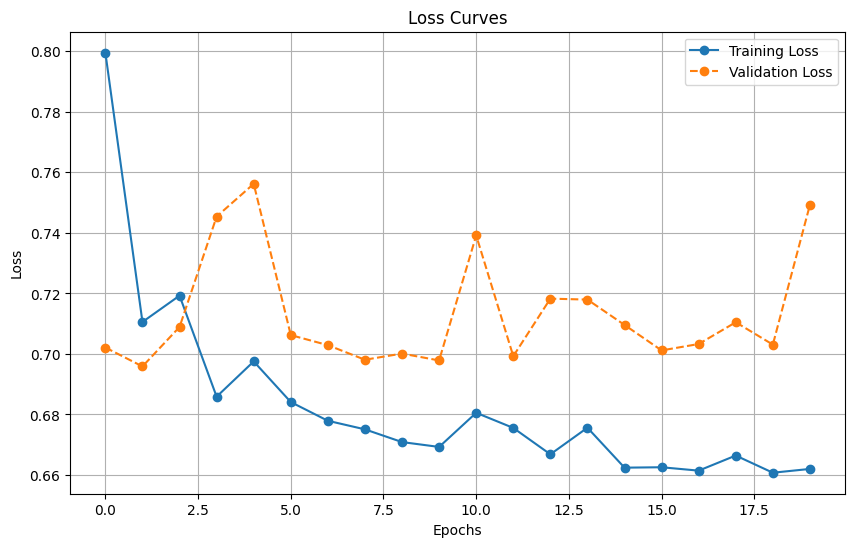

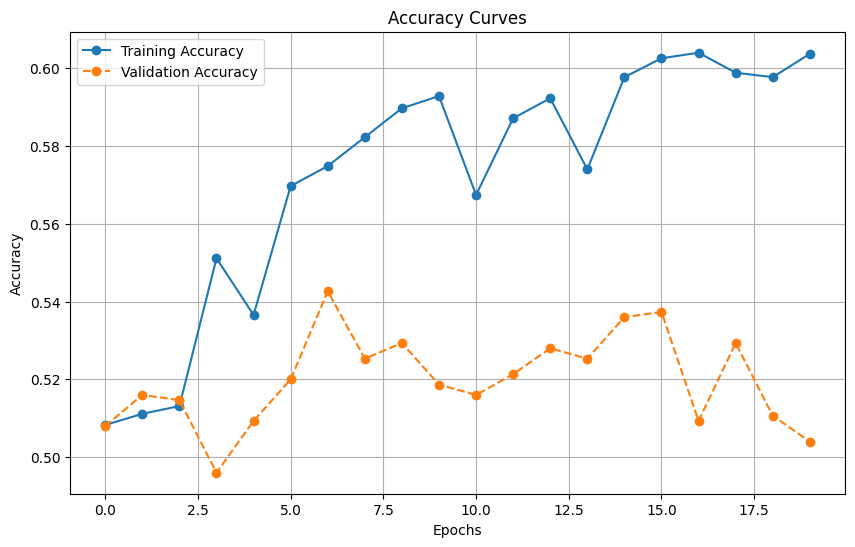

In [341]:
input_size = dataset.num_features 
hidden_size1 = 800
hidden_size2 = 600
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:61.57% Loss:0.6518 Val Acc:52.53% Loss:0.7197 Time/epoch:0.052s

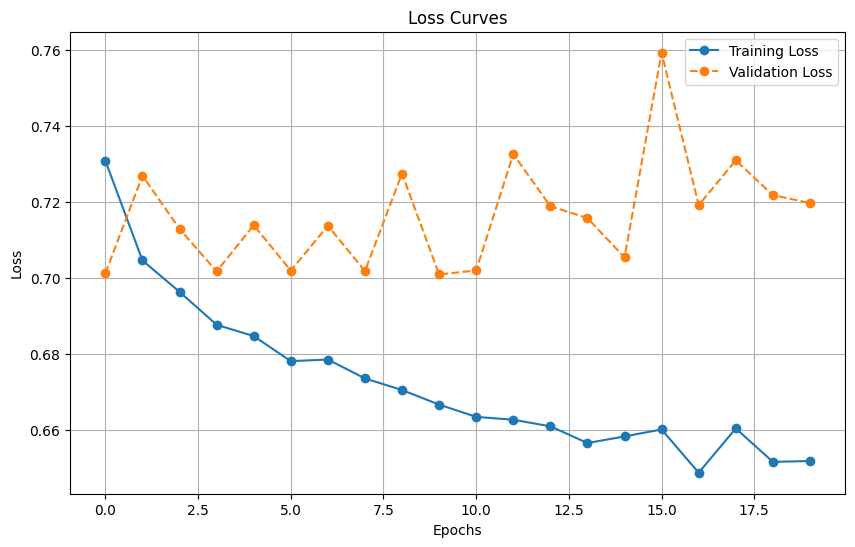

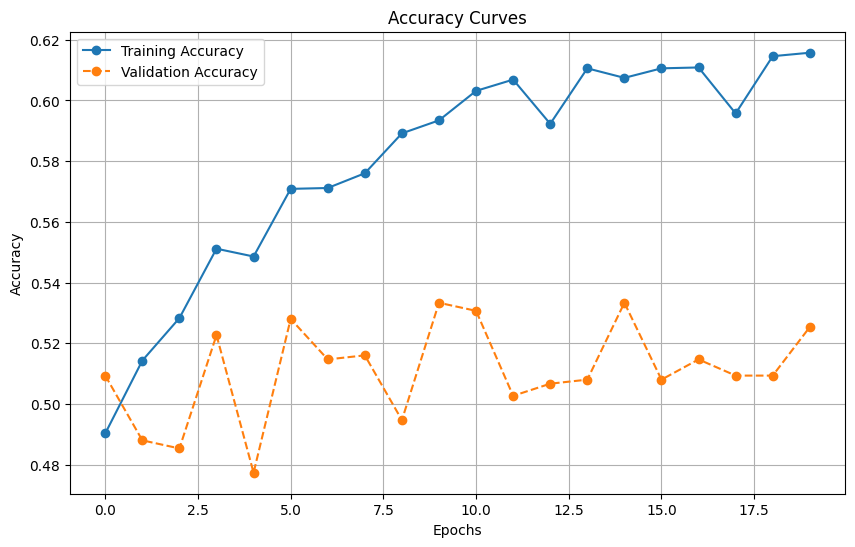

In [342]:
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:65.74% Loss:0.6209 Val Acc:52.27% Loss:0.7228 Time/epoch:0.056s

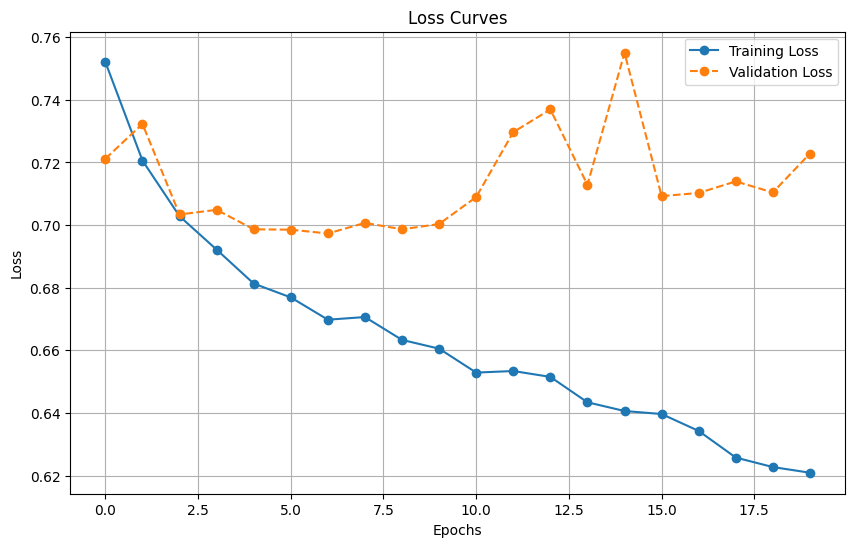

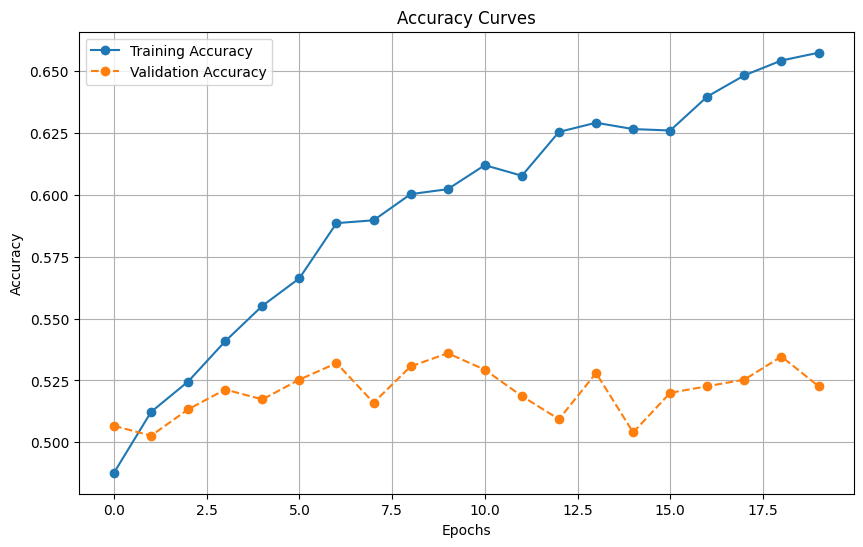

In [ ]:
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

#### Prueba de optimizadores

In [344]:
optimizers_to_test = [
    ("SGD", lambda model: get_sgd_optimizer(model, lr=0.01)),
    ("SGD + Momentum", lambda model: get_sgd_momentum_optimizer(model, lr=0.01, momentum=0.9)),
    ("SGD + Nesterov", lambda model: get_sgd_nesterov_optimizer(model, lr=0.01, momentum=0.9)),
    ("RMSProp", lambda model: get_rmsprop_optimizer(model, lr=0.01, alpha=0.99)),
    ("Adam", lambda model: get_adam_optimizer(model, lr=0.01, betas=(0.9, 0.999)))
]
initializations_to_test = [
    ("Xavier", init_xavier),
    ("He", init_he)
]

In [345]:
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    

In [346]:
results_df = []
optimizer_results = []

for init_name, init_fn in initializations_to_test:
    for opt_name, opt_fn in optimizers_to_test:
        print(f"Testing optimizer: {opt_name} with initialization: {init_name}")
        
        model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
        init_fn(model)  
        optimizer = opt_fn(model)
        
        train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
            model=model,
            optimizer=optimizer,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=20,
            reports_every=1,
            device='cuda'
        )
        
        optimizer_results.append({
            "Initialization": init_name,
            "Optimizer": opt_name,
            "Final Train Loss": train_losses[-1],
            "Final Val Loss": val_losses[-1],
            "Final Train Accuracy": train_accuracies[-1],
            "Final Val Accuracy": val_accuracies[-1]
        })

results_df = pd.DataFrame(optimizer_results)

Testing optimizer: SGD with initialization: Xavier
Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:56.89% Loss:0.6779 Val Acc:53.60% Loss:0.6968 Time/epoch:0.055sTesting optimizer: SGD + Momentum with initialization: Xavier
Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:67.00% Loss:0.6065 Val Acc:51.73% Loss:0.7304 Time/epoch:0.041sTesting optimizer: SGD + Nesterov with initialization: Xavier
Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1,

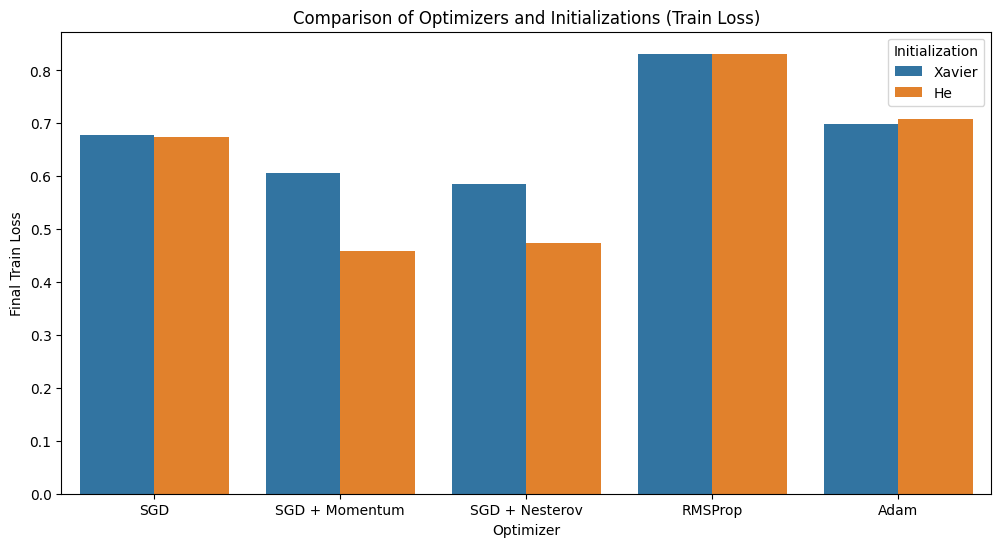

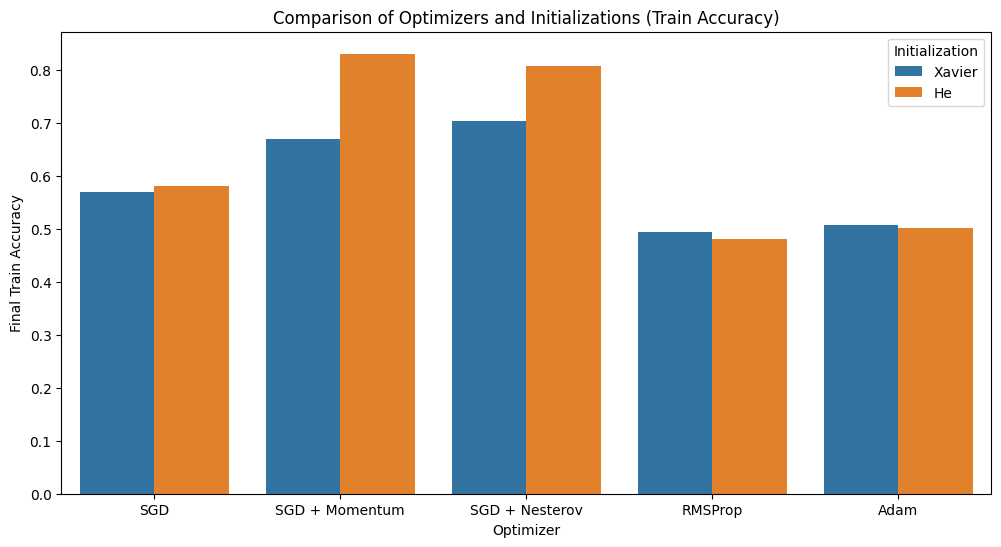

In [350]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Optimizer", y="Final Train Loss", hue="Initialization")
plt.title("Comparison of Optimizers and Initializations (Train Loss)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Optimizer", y="Final Train Accuracy", hue="Initialization")
plt.title("Comparison of Optimizers and Initializations (Train Accuracy)")
plt.show()

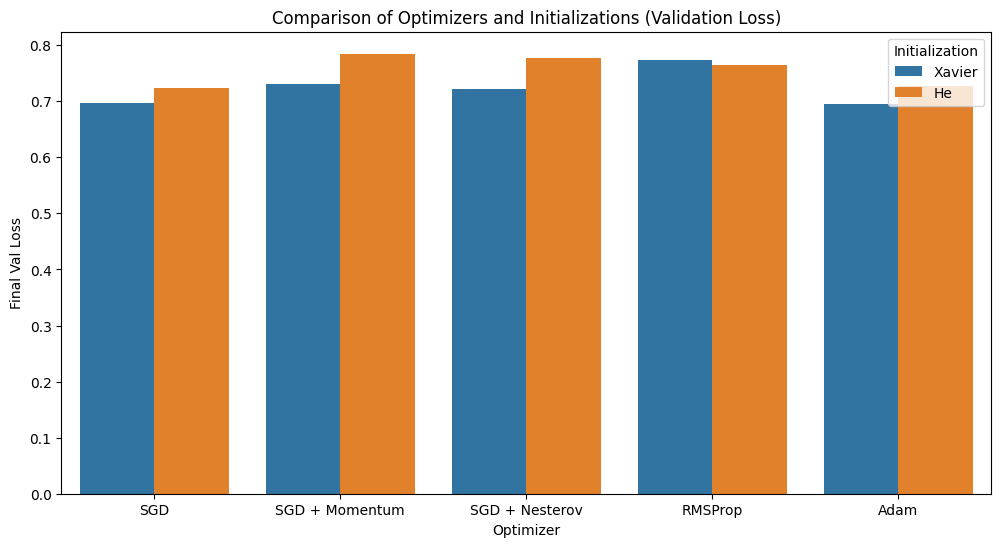

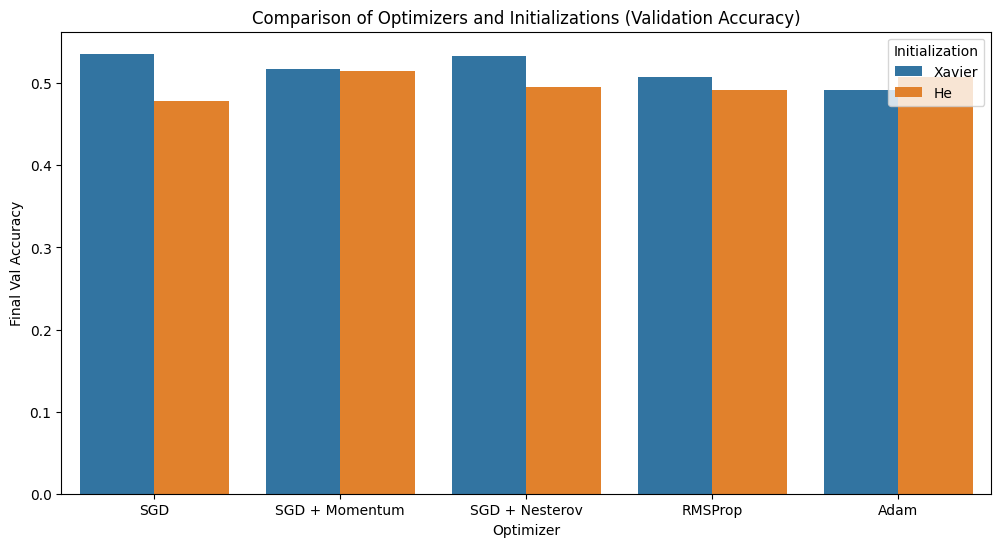

In [349]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Optimizer", y="Final Val Loss", hue="Initialization")
plt.title("Comparison of Optimizers and Initializations (Validation Loss)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Optimizer", y="Final Val Accuracy", hue="Initialization")
plt.title("Comparison of Optimizers and Initializations (Validation Accuracy)")
plt.show()

El mejor enfoque parece ser SGD + Momentum con He, ya que proporciona:
Mejor rendimiento de entrenamiento.
Balance razonable con los resultados de validación.
Mayor estabilidad en comparación con otras combinaciones.

In [30]:
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1

Dropout

Model: DropoutFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 150701
Epoch:020 Train Acc:66.26% Loss:0.6199 Val Acc:53.60% Loss:0.7070 Time/epoch:0.046s

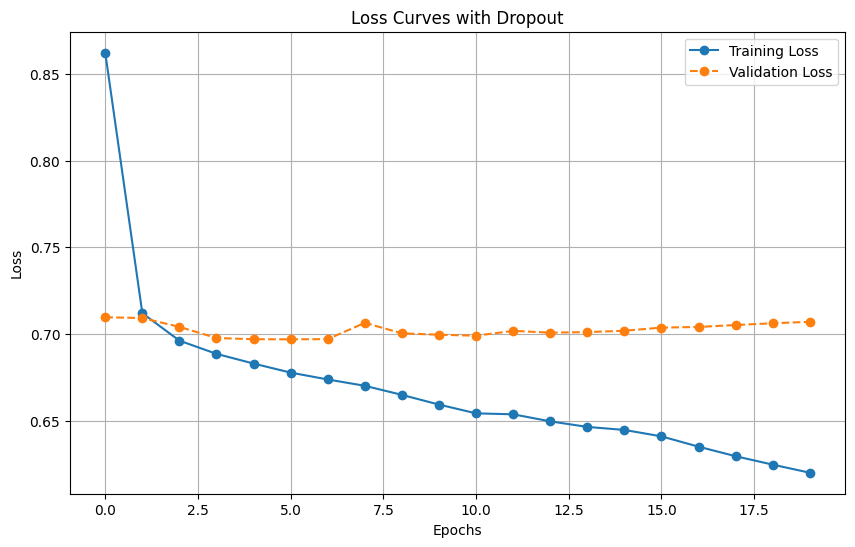

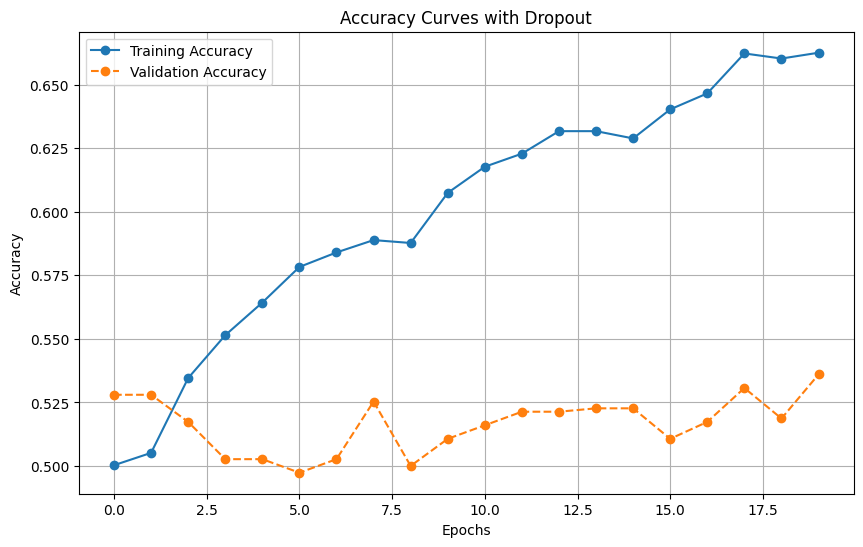

In [369]:
model = DropoutFFNN(input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.5) 
optimizer = get_sgd_momentum_optimizer(model, lr=0.005)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with Dropout")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with Dropout")

Batch Normalization

Model: BatchNormFFNN(
  (fc1): Linear(in_features=300, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 101401
Epoch:020 Train Acc:97.77% Loss:0.2311 Val Acc:50.40% Loss:0.9181 Time/epoch:0.054s

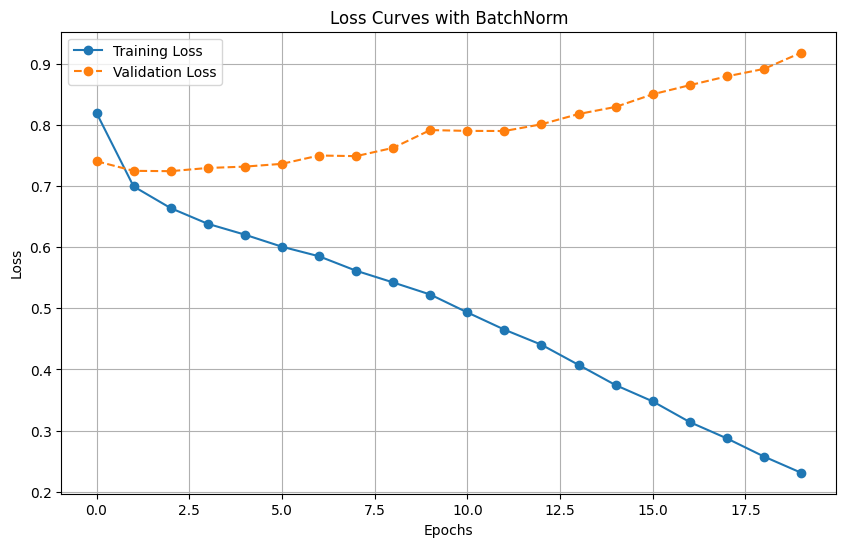

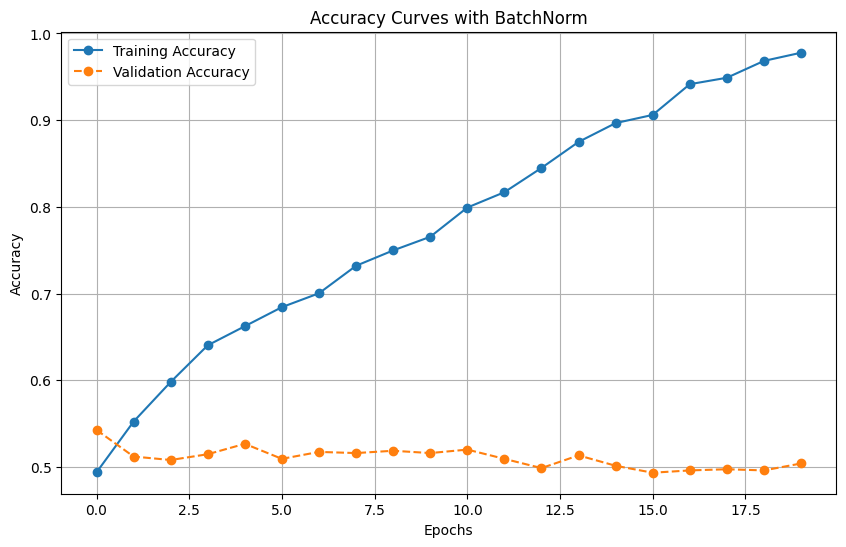

In [31]:
model = BatchNormFFNN(input_size=dataset.num_features, hidden_size1=hidden_size2, hidden_size2=hidden_size2, output_size=output_size)
optimizer = get_sgd_momentum_optimizer(model, lr=0.005)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with BatchNorm")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with BatchNorm")

Batch Normalization con Dropout

Model: BatchNormDropoutFFNN(
  (fc1): Linear(in_features=300, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 101401
Epoch:020 Train Acc:68.20% Loss:0.5980 Val Acc:48.27% Loss:0.7635 Time/epoch:0.056s

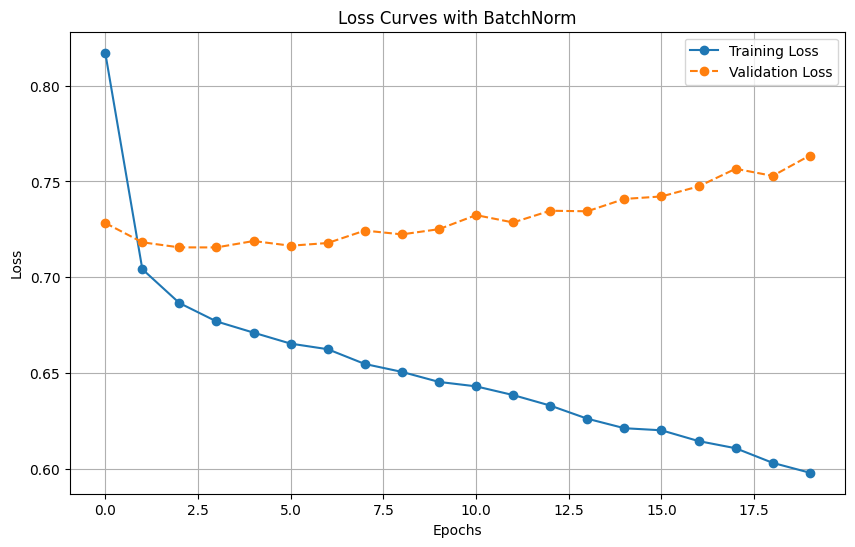

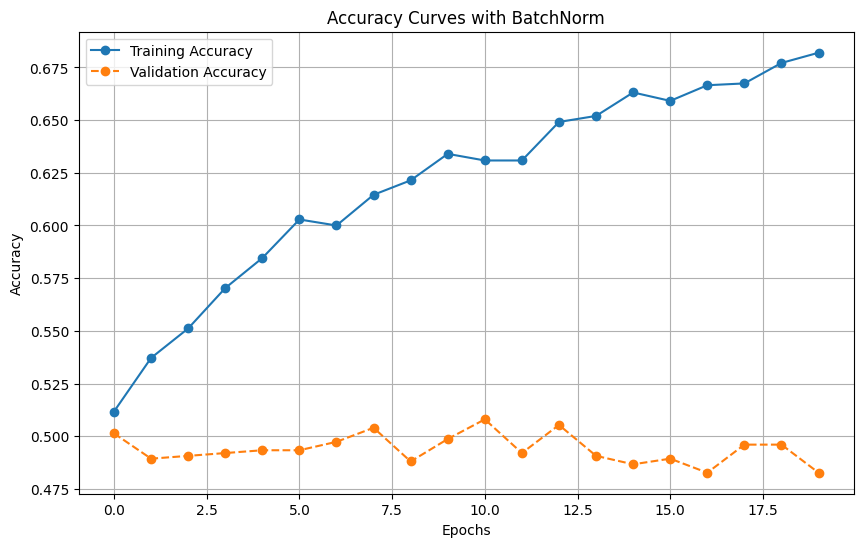

In [40]:
model = BatchNormDropoutFFNN(input_size=dataset.num_features, hidden_size1=hidden_size2, hidden_size2=hidden_size2, output_size=output_size)
optimizer = get_sgd_momentum_optimizer(model, lr=0.005)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with BatchNorm")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with BatchNorm")

Regularización l2

La regularización L2 se implementa directamente en el cálculo de la función de pérdida.

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:65.57% Loss:1.5183 Val Acc:51.73% Loss:0.7550 Time/epoch:0.082s

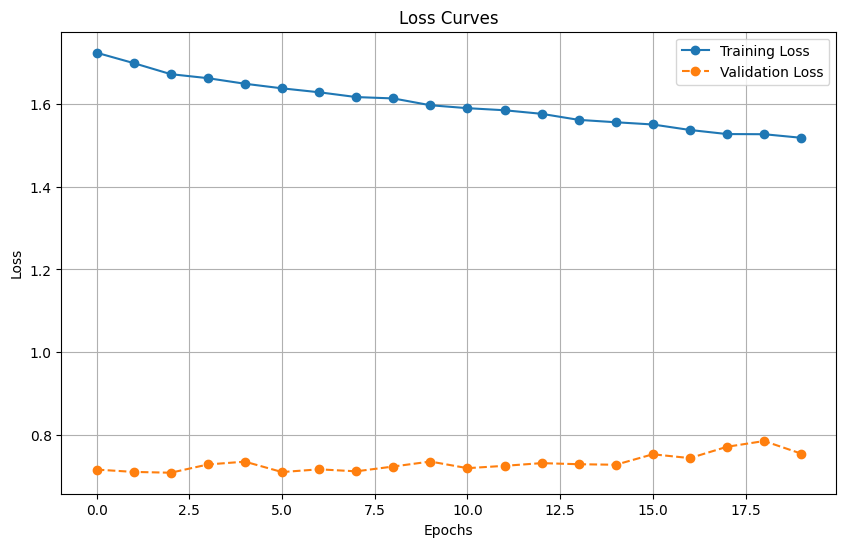

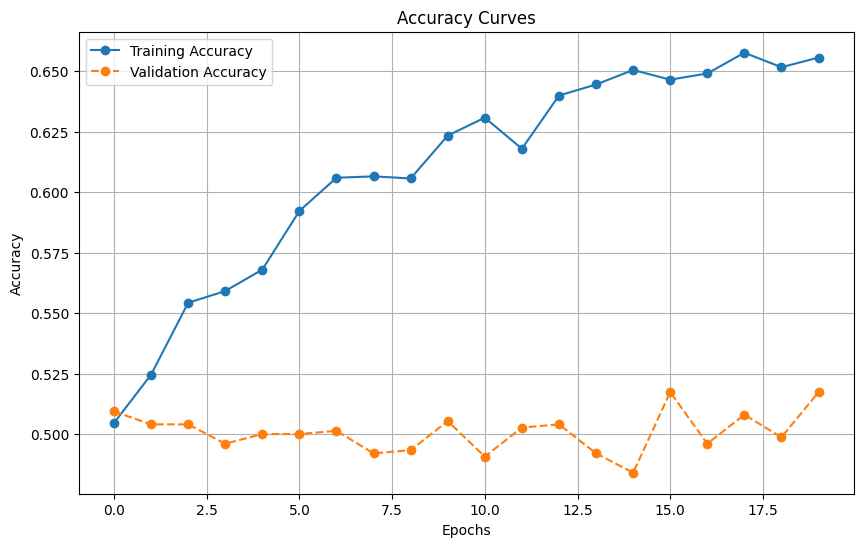

In [35]:
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    l2=True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

El término weight_decay en los optimizadores de PyTorch introduce la regularización L2 de forma implícita en el proceso de actualización de parámetros:

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:65.63% Loss:0.6160 Val Acc:51.60% Loss:0.7961 Time/epoch:0.049s

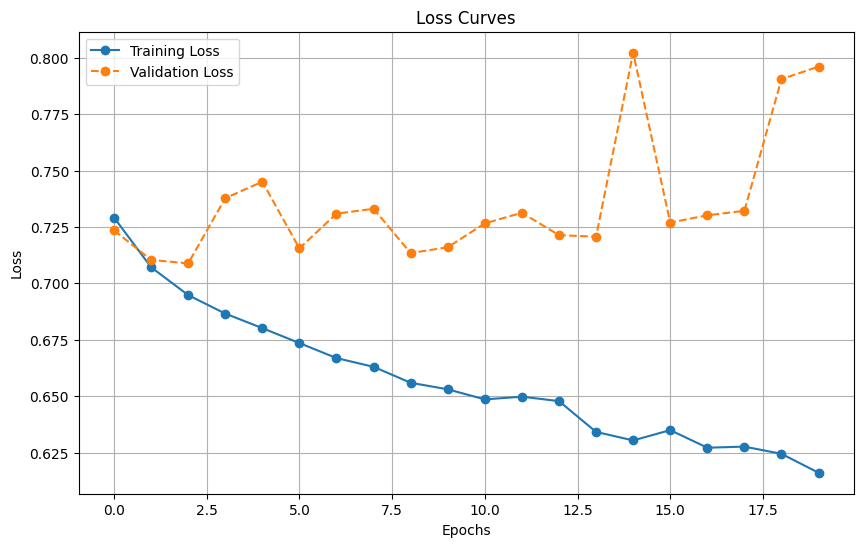

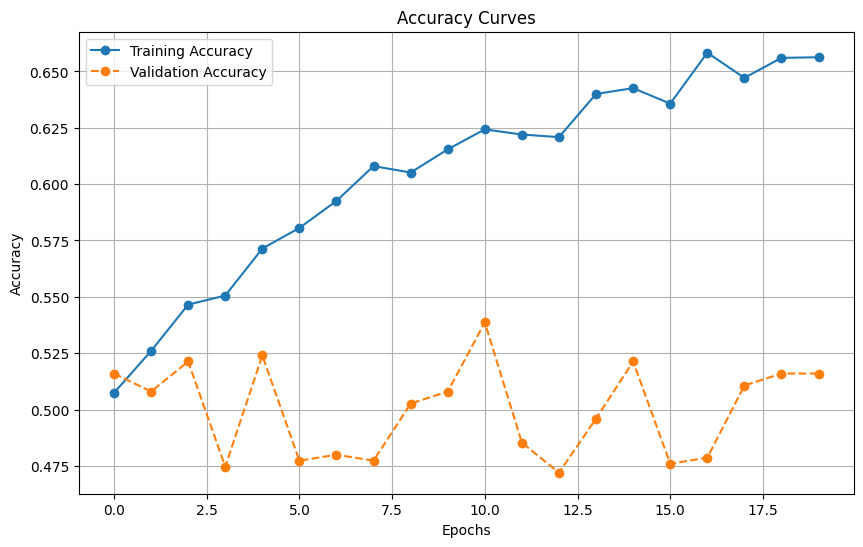

In [38]:
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

Técnicas de Regularización Juntas

Model: BatchNormDropoutFFNN(
  (fc1): Linear(in_features=300, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 101401
Epoch:020 Train Acc:68.17% Loss:0.6050 Val Acc:50.67% Loss:0.7607 Time/epoch:0.053s

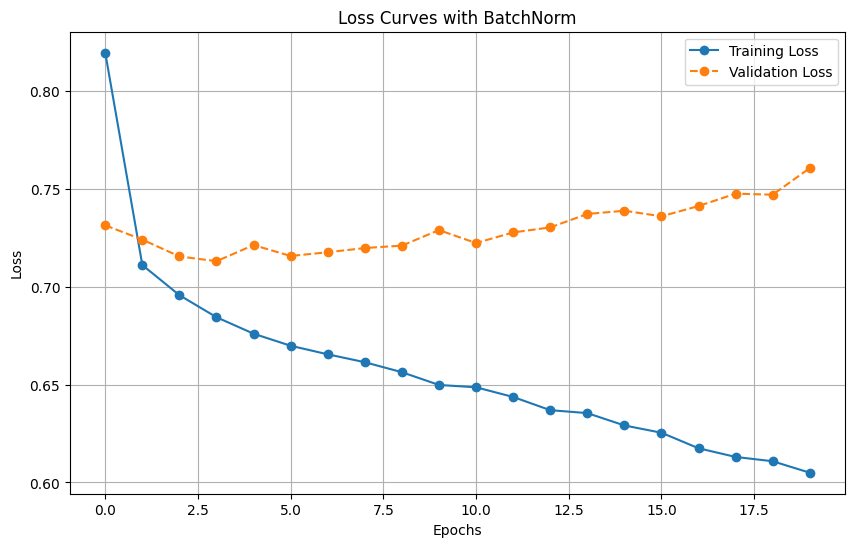

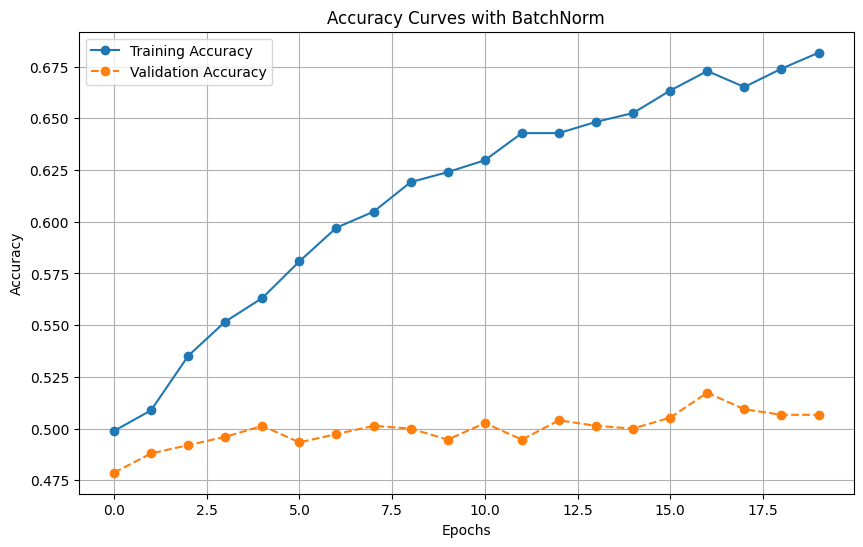

In [44]:
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = BatchNormDropoutFFNN(input_size=dataset.num_features, hidden_size1=hidden_size2, hidden_size2=hidden_size2, output_size=output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with BatchNorm")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with BatchNorm")

Agregando Early Stopping

Model: BatchNormDropoutFFNN(
  (fc1): Linear(in_features=300, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 101401
Epoch:011 Train Acc:62.71% Loss:0.6493 Val Acc:48.67% Loss:0.7338 Time/epoch:0.063s
Early stopping triggered after 12 epochs!


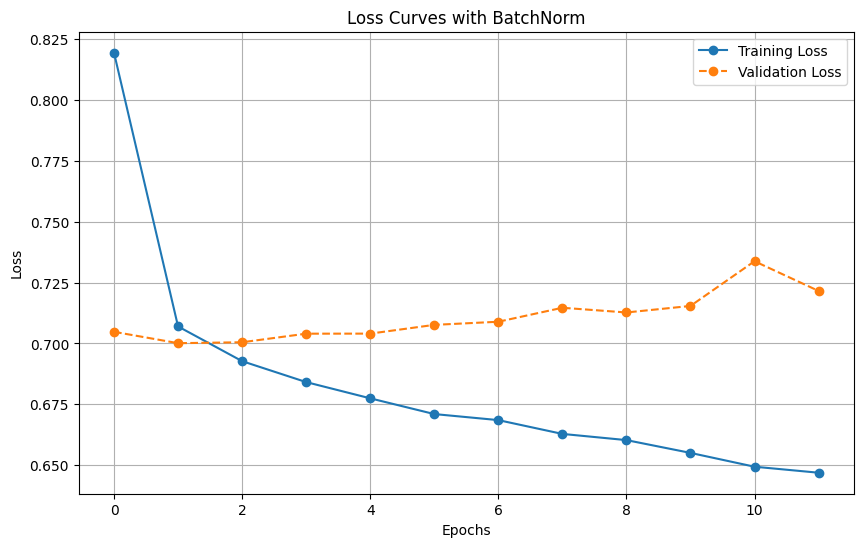

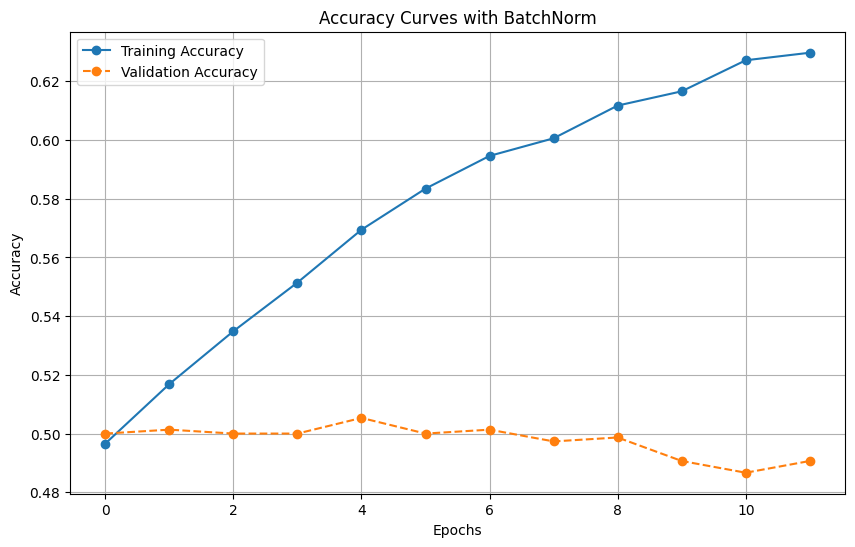

In [48]:
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = BatchNormDropoutFFNN(input_size=dataset.num_features, hidden_size1=hidden_size2, hidden_size2=hidden_size2, output_size=output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    use_early_stopping=True,
    patience=10
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with BatchNorm")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with BatchNorm")

Generar Subconjuntos de Datos usando Bootstrap

In [86]:
import torch
from torch.utils.data import DataLoader, Subset
import random

def create_bootstrap_samples(dataset, n_samples):
    subsets = []
    data_indices = list(range(len(dataset)))
    for _ in range(n_samples):
        sampled_indices = random.choices(data_indices, k=len(dataset)) 
        subsets.append(Subset(dataset, sampled_indices))
    return subsets

Entrenar Varias Redes con Diferentes Subconjuntos

In [87]:
def train_single_model_with_early_stopping(
    model, train_loader, val_loader=None, optimizer=None, epochs=10, patience=5
):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    losses = [] 
    val_losses = []
    criterion = torch.nn.BCELoss()

    best_val_loss = float('inf') 
    patience_counter = 0 
    best_model_state = None  

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model.forward(inputs)
            loss = criterion(predictions, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if val_loader:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    predictions = model.forward(inputs)
                    val_loss += criterion(predictions, targets).item()
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                best_model_state = model.state_dict()  
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered at epoch {epoch + 1}.")
                    model.load_state_dict(best_model_state) 
                    break
        
        sys.stdout.write(
            f"\rEpoch {epoch+1}/{epochs}, "
            f"Train Loss: {avg_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}" if val_loader else f"Train Loss: {avg_loss:.4f}"
        )
        sys.stdout.flush()

    return losses, val_losses if val_loader else None


In [94]:
def train_ensemble_with_early_stopping(
    dataset, n_models, input_size, hidden_size1, hidden_size2, output_size,
    epochs=10, patience=5, val_split=0.2
):
    bootstrap_samples = create_bootstrap_samples(dataset, n_models)
    models = []
    ensemble_train_losses = []
    ensemble_val_losses = []
    
    for i, subset in enumerate(bootstrap_samples):
        print(f"\nTraining model {i+1}/{n_models}")
        
        val_size = int(len(subset) * val_split)
        train_size = len(subset) - val_size
        train_subset, val_subset = random_split(subset, [train_size, val_size])
        
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
        
        model = BatchNormDropoutFFNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.3)
        optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
        
        train_losses, val_losses = train_single_model_with_early_stopping(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            epochs=epochs,
            patience=patience
        )

        ensemble_train_losses.append(train_losses)
        ensemble_val_losses.append(val_losses)

        
        models.append(model)
    
    return models, ensemble_train_losses, ensemble_val_losses


In [89]:
def train_single_model(model, train_loader, optimizer, epochs=10):
    device = 'cuda' if torch.cuda.is_available() else 'cpu' 
    model.to(device)
    losses = [] 
    criterion = torch.nn.BCELoss()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device) 
            predictions = model.forward(inputs)
            L = criterion(predictions, targets)
            L.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += L.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        sys.stdout.write(f"\rEpoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        sys.stdout.flush()
    return losses

def train_ensemble(dataset, n_models, input_size, hidden_size1, hidden_size2, output_size, epochs=10):
    bootstrap_samples = create_bootstrap_samples(dataset, n_models)
    models = []
    for i, subset in enumerate(bootstrap_samples):
        print(f"\nTraining model {i+1}/{n_models}")
        train_loader = DataLoader(subset, batch_size=64, shuffle=True)
        model = BatchNormDropoutFFNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.3)
        optimizer =  get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
        
        train_single_model(model, train_loader, optimizer, epochs)
        models.append(model)
    return models




In [90]:
def evaluate_single_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            predictions = model(inputs)
            predictions_binary = (predictions > 0.5).float()
            correct += (predictions_binary == targets).sum().item()
            total += targets.size(0)
    return correct / total


In [91]:
def ensemble_predict(models, data_loader):
    ensemble_outputs = []
    for batch in data_loader:
        inputs, _ = batch
        predictions = torch.zeros(len(models), len(inputs))
        for i, model in enumerate(models):
            model.eval()
            with torch.no_grad():
                predictions[i] = model(inputs).squeeze()
        averaged_predictions = predictions.mean(dim=0)
        ensemble_outputs.append(averaged_predictions)
    return torch.cat(ensemble_outputs)

In [92]:
def evaluate_ensemble(models, data_loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu' 
    all_predictions = []
    true_labels = []

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        ensemble_preds = []

        for model in models:
            model.eval()
            with torch.no_grad():
                preds = model(inputs)
                ensemble_preds.append(preds.squeeze())
        
        averaged_preds = torch.stack(ensemble_preds, dim=0).mean(dim=0)
        all_predictions.append(averaged_preds)
        true_labels.append(targets)
    
    all_predictions = torch.cat(all_predictions)
    true_labels = torch.cat(true_labels)
    predicted_classes = (all_predictions >= 0.5).float()
    accuracy = (predicted_classes == true_labels).float().mean().item()
    return accuracy


In [ ]:
n_models = 10
epochs = 20
batch_size = 128 
models, train_losses, val_losses = train_ensemble_with_early_stopping(
    dataset=train_dataset,
    n_models=n_models,
    input_size = dataset.num_features,
    hidden_size1 = 300,
    hidden_size2 = 200,
    output_size = 1,
    epochs=epochs
)
accuracy = evaluate_ensemble(models, test_loader)
print(f"\nEnsemble Accuracy: {accuracy:.2f}")



Training model 1/10
Epoch 17/20, Train Loss: 0.2679, Val Loss: 0.6756
Early stopping triggered at epoch 18.

Training model 2/10
Epoch 19/20, Train Loss: 0.2277, Val Loss: 0.7312
Early stopping triggered at epoch 20.

Training model 3/10
Epoch 19/20, Train Loss: 0.2516, Val Loss: 0.6418
Early stopping triggered at epoch 20.

Training model 4/10
Epoch 19/20, Train Loss: 0.2401, Val Loss: 0.5554
Early stopping triggered at epoch 20.

Training model 5/10
Epoch 19/20, Train Loss: 0.2417, Val Loss: 0.6773
Early stopping triggered at epoch 20.

Training model 6/10
Epoch 19/20, Train Loss: 0.2424, Val Loss: 0.6951
Early stopping triggered at epoch 20.

Training model 7/10
Epoch 18/20, Train Loss: 0.2460, Val Loss: 0.6797
Early stopping triggered at epoch 19.

Training model 8/10
Epoch 7/20, Train Loss: 0.5189, Val Loss: 0.6803
Early stopping triggered at epoch 8.

Training model 9/10
Epoch 19/20, Train Loss: 0.2449, Val Loss: 0.5967
Early stopping triggered at epoch 20.

Training model 10/10

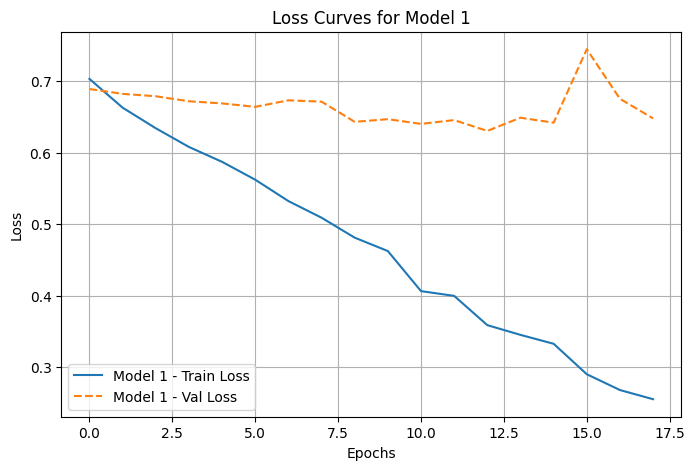

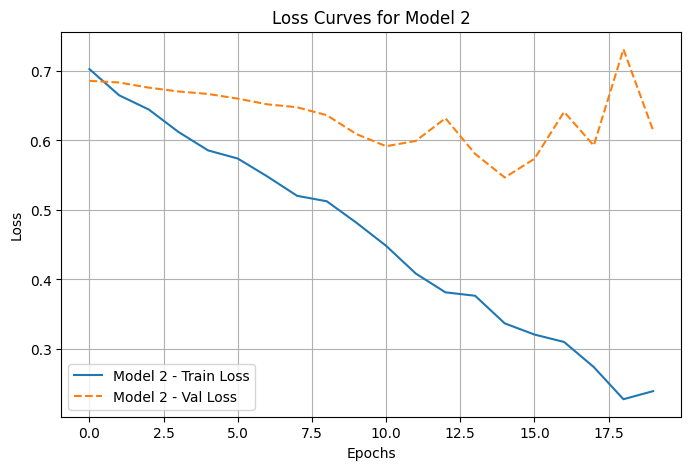

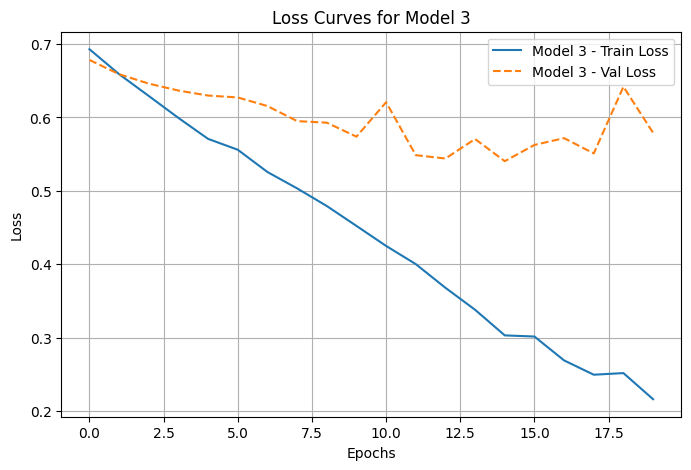

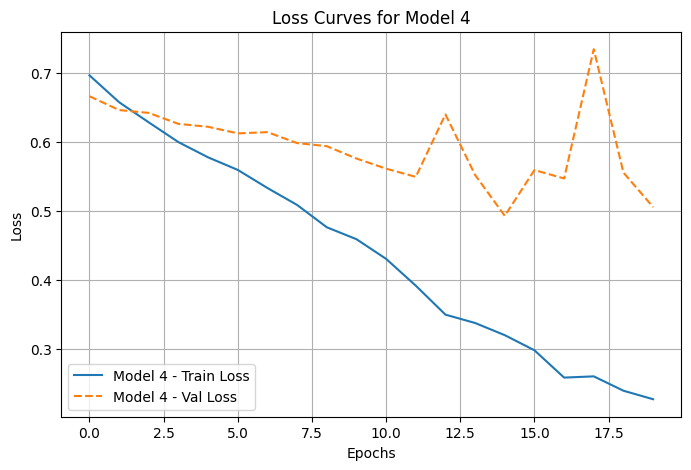

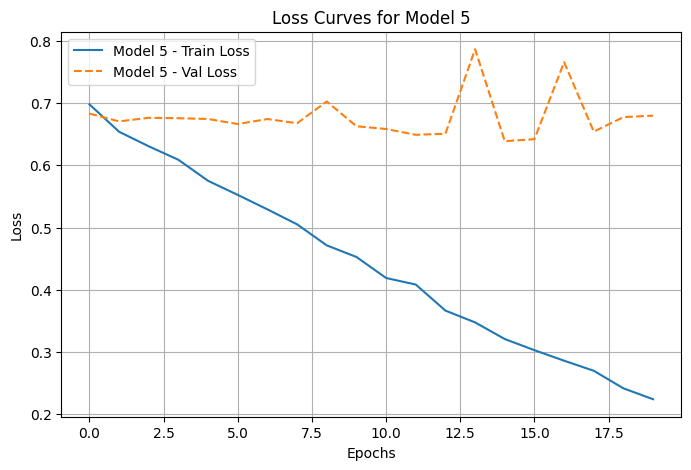

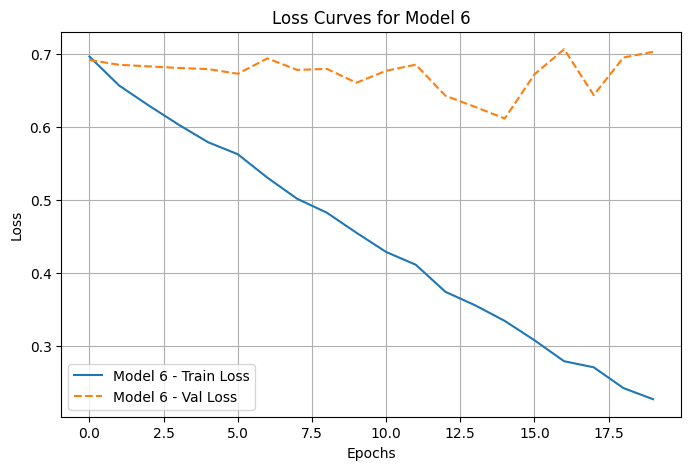

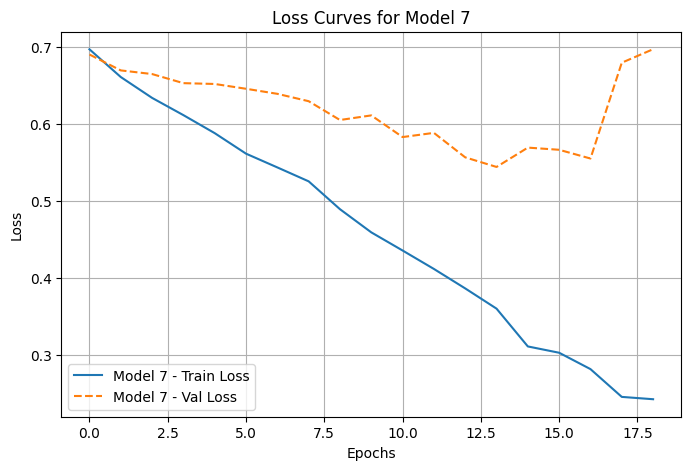

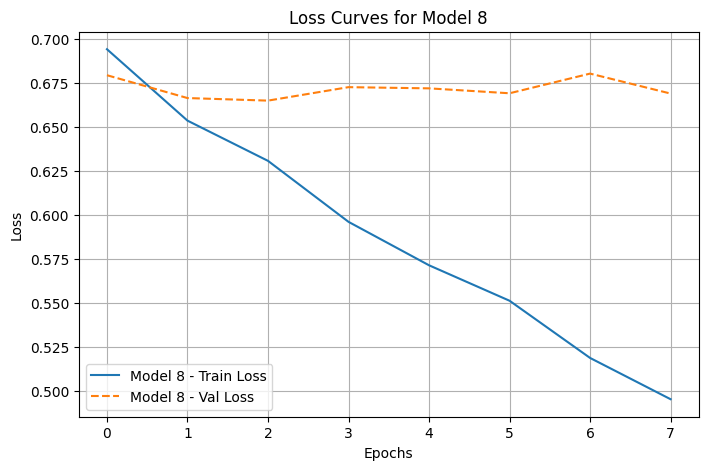

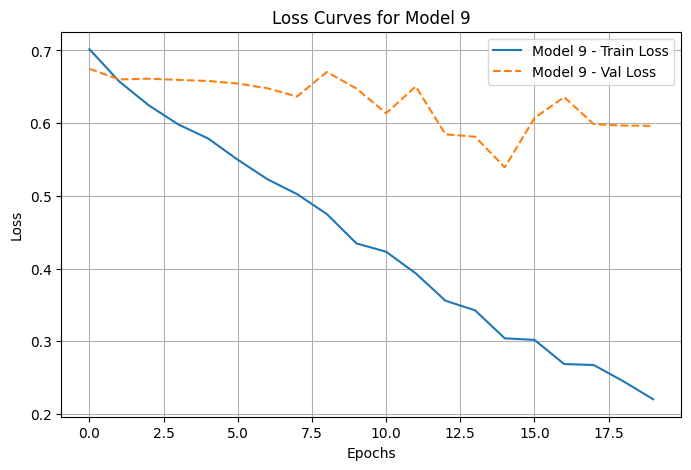

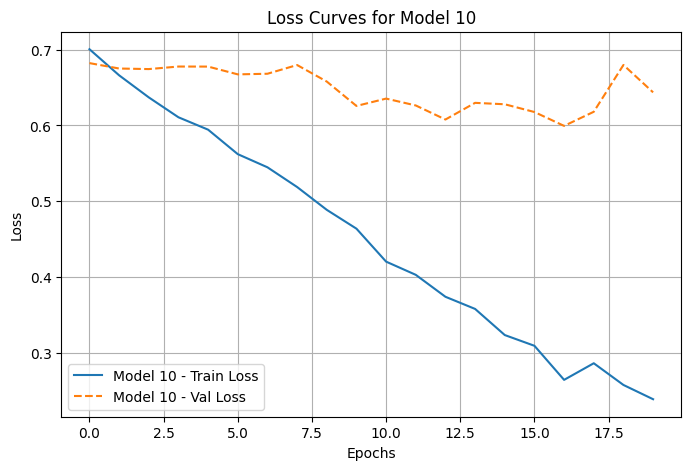

In [96]:
for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label=f"Model {i+1} - Train Loss")
    plt.plot(val_loss, label=f"Model {i+1} - Val Loss", linestyle="--")
    plt.title(f"Loss Curves for Model {i+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [97]:
final_train_losses = [loss[-1] for loss in train_losses]
final_val_losses = [loss[-1] for loss in val_losses]

for i, (train_loss, val_loss) in enumerate(zip(final_train_losses, final_val_losses)):
    print(f"Model {i+1} - Final Train Loss: {train_loss:.4f}, Final Val Loss: {val_loss:.4f}")


Model 1 - Final Train Loss: 0.2550, Final Val Loss: 0.6481
Model 2 - Final Train Loss: 0.2393, Final Val Loss: 0.6146
Model 3 - Final Train Loss: 0.2160, Final Val Loss: 0.5791
Model 4 - Final Train Loss: 0.2279, Final Val Loss: 0.5056
Model 5 - Final Train Loss: 0.2243, Final Val Loss: 0.6797
Model 6 - Final Train Loss: 0.2271, Final Val Loss: 0.7030
Model 7 - Final Train Loss: 0.2430, Final Val Loss: 0.6971
Model 8 - Final Train Loss: 0.4954, Final Val Loss: 0.6689
Model 9 - Final Train Loss: 0.2203, Final Val Loss: 0.5963
Model 10 - Final Train Loss: 0.2390, Final Val Loss: 0.6437


Pasando a otra BD

In [105]:
from sklearn.model_selection import train_test_split

train_ratio = 0.7
val_ratio = 0.15  
test_ratio = 0.15  
X = weather_data.drop(columns=['RainTomorrow'])
y = weather_data['RainTomorrow']


X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_ratio/(train_ratio + val_ratio), random_state=42, stratify=y_train_val
)
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_val)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

Tamaño del conjunto de entrenamiento: 17499
Tamaño del conjunto de validación: 3751
Tamaño del conjunto de prueba: 3750


In [114]:
X_train = X_train.astype({col: 'int32' for col in X_train.select_dtypes(include='bool').columns})
X_val = X_val.astype({col: 'int32' for col in X_val.select_dtypes(include='bool').columns})
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

In [121]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
print("Columnas categóricas:", categorical_columns)


Columnas categóricas: Index(['RainToday'], dtype='object')


In [122]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [123]:
y_train = y_train.replace({'No': 0, 'Yes': 1}).astype('float32')
y_val = y_val.replace({'No': 0, 'Yes': 1}).astype('float32')
y_test = y_test.replace({'No': 0, 'Yes': 1}).astype('float32')


In [127]:
common_columns = X_train.columns.intersection(X_val.columns).intersection(X_test.columns)
X_train = X_train[common_columns]
X_val = X_val[common_columns]
X_test = X_test[common_columns]


In [155]:
batch_size = 128
train_loader = DataLoader(
    list(zip(torch.tensor(X_train.values, dtype=torch.float32), 
             torch.tensor(y_train.values[:, None], dtype=torch.float32))),  # Asegura (N, 1)
    batch_size=batch_size, shuffle=True
)

val_loader = DataLoader(
    list(zip(torch.tensor(X_val.values, dtype=torch.float32), 
             torch.tensor(y_val.values[:, None], dtype=torch.float32))),
    batch_size=batch_size, shuffle=False
)

test_loader = DataLoader(
    list(zip(torch.tensor(X_test.values, dtype=torch.float32), 
             torch.tensor(y_test.values[:, None], dtype=torch.float32))),
    batch_size=batch_size, shuffle=False
)

Model: SimpleFFNN(
  (fc1): Linear(in_features=75, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)
Number of parameters: 35401
Epoch:020 Train Acc:99.41% Loss:0.0247 Val Acc:98.91% Loss:0.0312 Time/epoch:0.149s

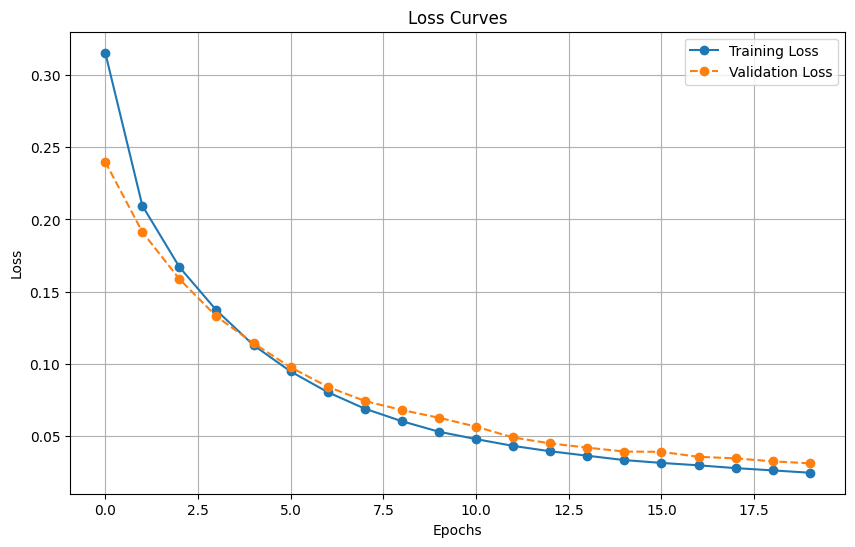

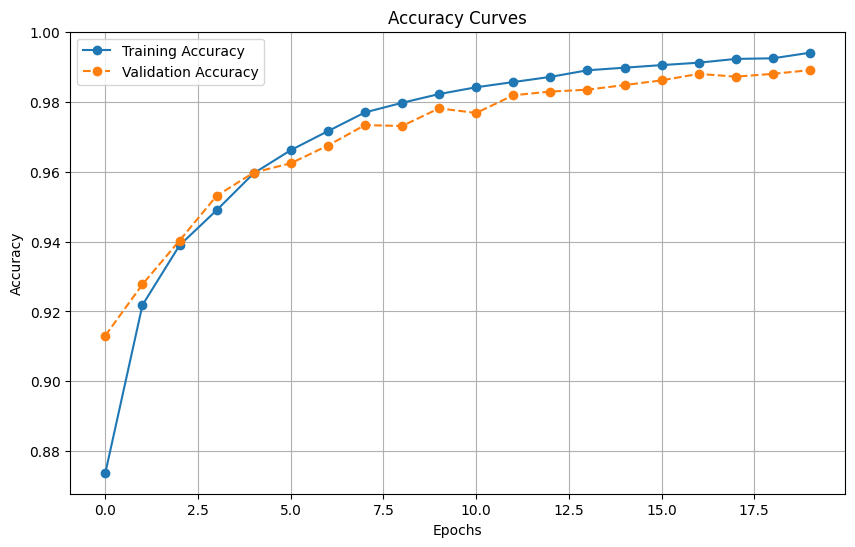

In [156]:
input_size = X_train.shape[1]  # Número de características después de preprocesamiento
hidden_size1 = 200
hidden_size2 = 100
output_size = 1
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

Model: SimpleFFNN(
  (fc1): Linear(in_features=75, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)
Number of parameters: 35401
Epoch:020 Train Acc:99.27% Loss:0.0256 Val Acc:98.91% Loss:0.0312 Time/epoch:0.171s

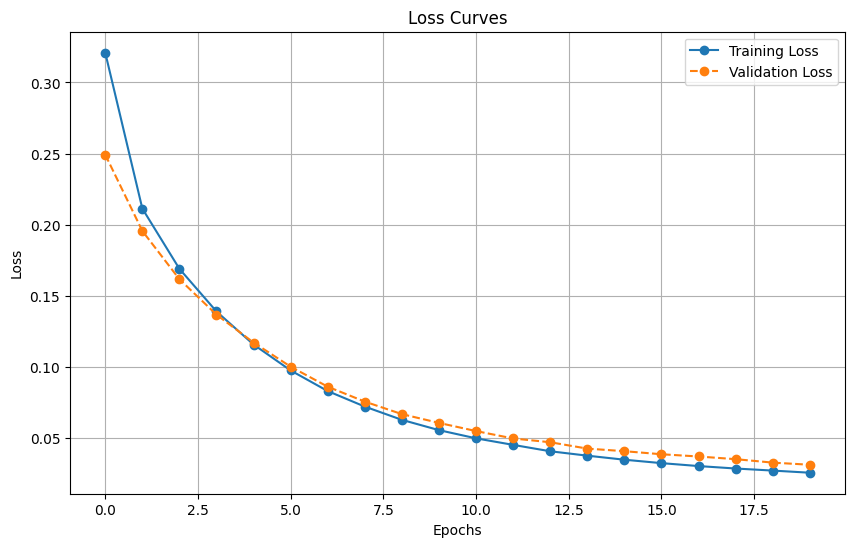

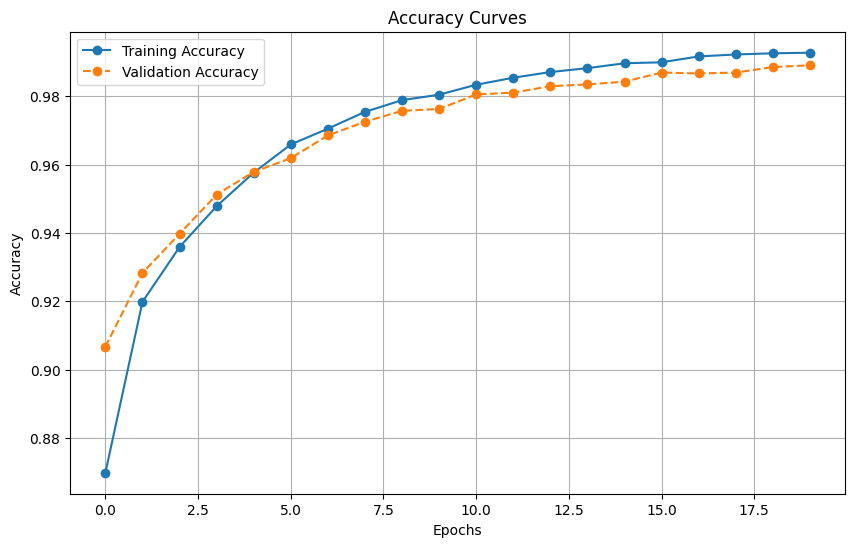

In [157]:
input_size = X_train.shape[1] 
hidden_size1 = 200
hidden_size2 = 100
output_size = 1
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    use_early_stopping=True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

Model: SimpleFFNN(
  (fc1): Linear(in_features=75, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)
Number of parameters: 35401
Epoch:020 Train Acc:99.36% Loss:0.0240 Val Acc:98.99% Loss:0.0282 Time/epoch:0.157s

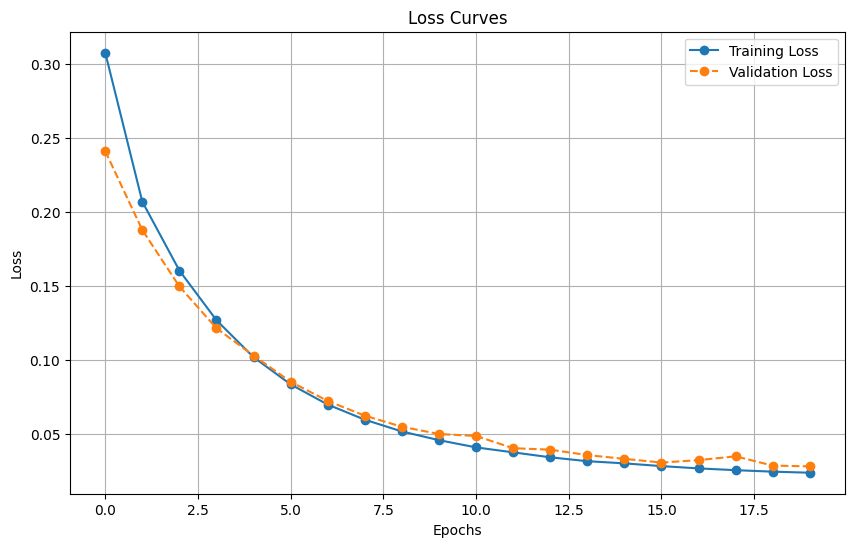

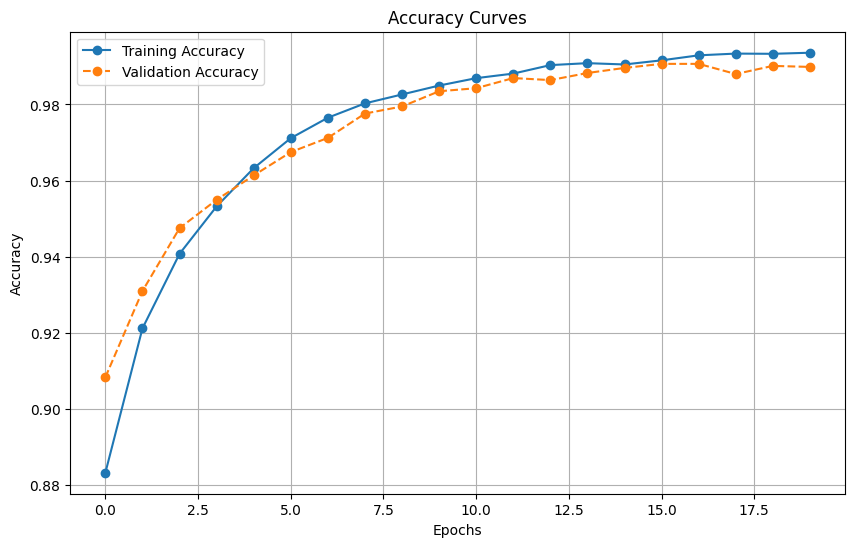

In [158]:
input_size = X_train.shape[1] 
hidden_size1 = 200
hidden_size2 = 100
output_size = 1
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    use_early_stopping=True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

Model: DropoutFFNN(
  (fc1): Linear(in_features=75, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.65, inplace=False)
)
Number of parameters: 821
Epoch:020 Train Acc:99.44% Loss:0.0197 Val Acc:99.25% Loss:0.0230 Time/epoch:0.192s

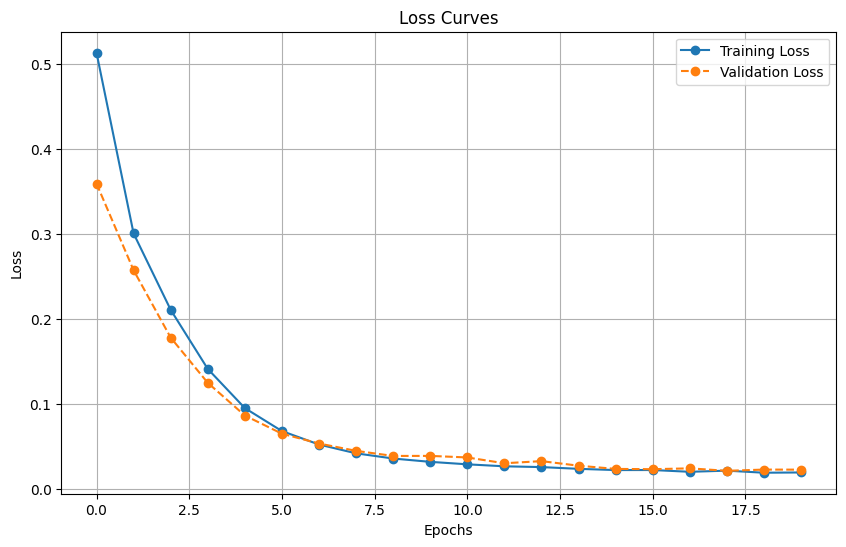

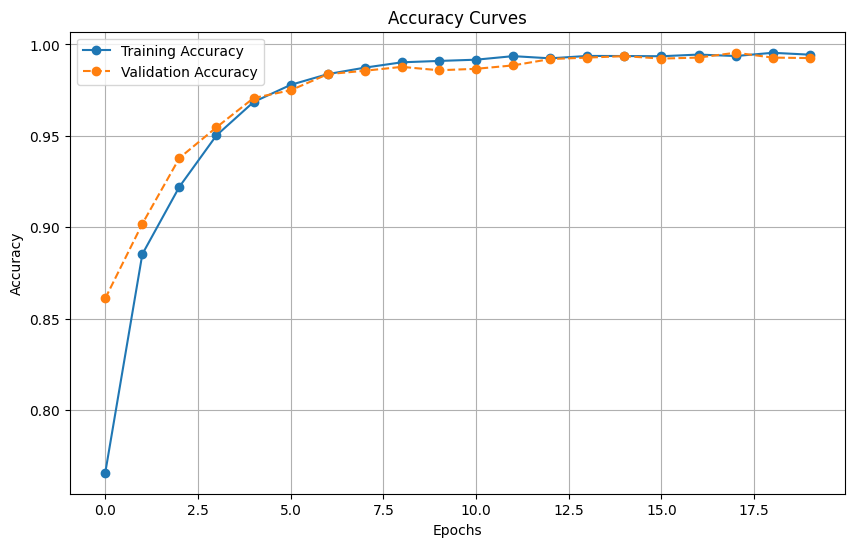

In [208]:
input_size = X_train.shape[1] 
hidden_size1 = 10
hidden_size2 = 5
output_size = 1
model = DropoutFFNN(input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.65)
optimizer = get_sgd_nesterov_optimizer(model, lr=0.009, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    use_early_stopping=True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

In [209]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    criterion = torch.nn.BCELoss()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model.forward(inputs)
            loss = criterion(predictions, targets)
            total_loss += loss.item()
            predictions_binary = (predictions >= 0.5).float()
            correct_predictions += (predictions_binary == targets).sum().item()
            total_samples += targets.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples * 100
    return avg_loss, accuracy

test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0229, Test Accuracy: 99.23%


Intentar con ensamble